# BiLSTM with Attention Layer for Sentiment Analysis

## Import the Required Libraries

In [ ]:
!pip install pydot
!pip install graphviz
%pip install wordcloud spacy scikit-learn pandas matplotlib seaborn
!pip install --force tensorflow
!pip install numpy==1.26.1

Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.12.23-py2.py3-none-any.whl.metadata (876 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached protobuf-5.29.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached setuptools-75.8.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached six-1.17.0-py2.py3-none

## Load Pre-trained Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2025-01-08 11:02:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-01-08 11:02:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-08 11:02:58--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import spacy

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2025-01-09 10:59:54.283883: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 10:59:54.285114: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 10:59:54.287917: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 10:59:54.295390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736420394.308644   25303 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736420394.31

In [ ]:
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm

2025-01-09 10:59:57.222171: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 10:59:57.223260: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 10:59:57.226024: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 10:59:57.233458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736420397.246763   25643 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736420397.25

## Create a customed function for visualizing the accuracy and loss in training

In [ ]:
def plot_history(history):

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', c='green', lw='2')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='orangered', lw='2')
    plt.title('Accuracy', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', c='green', lw='2')
    plt.plot(history.history['val_loss'], label='Validation Loss', c='orangered', lw='2')
    plt.title('Loss', loc='left', fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

## Load the IMDB review data

In [ ]:
!pip install s3fs==2023.9.2

  Using cached urllib3-1.26.20-py2.py3-none-any.whl.metadata (50 kB)
Using cached urllib3-1.26.20-py2.py3-none-any.whl (144 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.3.0
    Uninstalling urllib3-2.3.0:
      Successfully uninstalled urllib3-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker 2.227.0 requires protobuf<5.0,>=3.12, but you have protobuf 5.29.3 which is incompatible.
sagemaker-jupyterlab-extension-common 0.1.30 requires aiobotocore>=2.7.0, but you have aiobotocore 2.5.4 which is incompatible.
sagemaker-ui-helper 1.0.0 requires botocore>=1.34.106, but you have botocore 1.31.17 which is incompatible.


In [ ]:
import s3fs

fs=s3fs.S3FileSystem(anon=False)

s3_bucket_path='s3://amazon-sagemaker-058264306111-us-east-1-e23504aef6c5/dzd_5l5kah6gnsnq3r/bzbm82rtfbxpgn/dev/'
df = pd.read_csv(s3_bucket_path+'IMDBMovieReviews.csv')
print('No. of rows and columns :', df.shape)
df.head()

No. of rows and columns : (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Preprocess the data

In [ ]:
import spacy
import pandas as pd
from tqdm import tqdm
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])  # Disable components we don't need

# Define a function to process a single review
def normalize_single_review(doc, lowercase=True, remove_stopwords=True):
    lemmatized = []
    for token in doc:
        lemma = token.lemma_.lower() if lowercase else token.lemma_
        if not remove_stopwords or (remove_stopwords and not token.is_stop):
            lemmatized.append(lemma)
    return " ".join(lemmatized)

# Process the dataset in chunks
def process_in_chunks(df, chunk_size=1000, batch_size=500, lowercase=True, remove_stopwords=True):
    results = []

    for i in tqdm(range(0, len(df), chunk_size)):  # Loop through the dataset in chunks
        chunk = df['review'].iloc[i:i+chunk_size].tolist()

        # Process each chunk using spaCy's pipe for efficiency
        processed_chunk = []
        for doc in nlp.pipe(chunk, batch_size=batch_size, n_process=1):  # Use a limited number of processes
            processed_chunk.append(normalize_single_review(doc, lowercase=lowercase, remove_stopwords=remove_stopwords))

        results.extend(processed_chunk)  # Add the processed chunk to results

    return results

In [ ]:
#methods from nltk
# to remove non alphanumeric character
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

# to remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# to remove html tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [ ]:
df['review'] = df['review'].apply(remove_URL)
df['review'] = df['review'].apply(remove_html)
df['review'] = df['review'].apply(alpha_num)
# df['review'] = df['review'].apply(normalize, lowercase=True, remove_stopwords=True)
df['review'] = process_in_chunks(df, chunk_size=1000, batch_size=500, lowercase=True, remove_stopwords=True)

df.head()

100%|██████████| 50/50 [07:34<00:00,  9.09s/it]


,review,sentiment
0,reviewer mention watch 1 oz episode ll hook ri...,positive
1,wonderful little production film technique una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically s family little boy jake think s zom...,negative
4,petter matteis love time money visually stunni...,positive


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df['sentiment'])
df['labels'] = label_encoder.transform(df['sentiment'])

In [ ]:
# train-test split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(df['review'], df['labels'], test_size=0.2, random_state=5, stratify=df['labels'])


## Prepare the data for Deep Learning models

- **Tokenizer**: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

> This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

> By default, all punctuation is removed, turning the texts into space-separated sequences of words (words may include the ' character). These sequences are then split into lists of tokens. They will then be indexed or vectorized.

> 0 is a reserved index that won't be assigned to any word.


- **tokenizer.fit_on_texts**: Updates internal vocabulary based on a list of texts.

> In the case where texts contains lists, we assume each entry of the lists to be a token.

> Required before using texts_to_sequences or texts_to_matrix.


- **tokenizer.texts_to_sequences**: Transforms each text in texts to a sequence of integers.

> Only top num_words-1 most frequent words will be taken into account. Only words known by the tokenizer will be taken into account.

- **pad_sequences**: https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

> This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.

> Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long.

> Sequences longer than num_timesteps are truncated so that they fit the desired length.

> The position where padding or truncation happens is determined by the arguments padding and truncating, respectively. Pre-padding or removing values from the beginning of the sequence is the default.


In [ ]:
# model parameters
embedding_dim = 100
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>" # out of vocabulary

# tokenize sentences
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, truncating= trunc_type, padding=padding_type, maxlen=max_length)

# convert validation dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, truncating= trunc_type, padding=padding_type, maxlen=max_length)


vocab_size = len(word_index)


In [ ]:
# load the pre-trained GloVe word embeddings
EMBEDDING_FILE = './glove.6B.100d.txt'
word_vectors = {}
with open(EMBEDDING_FILE, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_vectors[word] = coefs

In [ ]:
# create the embedding matrix
embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = word_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from tensorflow import keras
from tensorflow.keras import backend as K


def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Build Deep Learning models with GloVe embedding

### tf.keras.sequential: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

Sequential groups a linear stack of layers into a tf.keras.Model.

How to create RNN models with keras and tensorflow: https://www.tensorflow.org/guide/keras/rnn


### EarlyStopping: https://keras.io/api/callbacks/early_stopping/

> Stop training when a monitored metric has stopped improving.

> Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'. A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.

> The quantity to be monitored needs to be available in logs dict. To make it so, pass the loss or metrics at model.compile().



* **monitor**: Quantity to be monitored.
* **min_delta**: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
* **patience**: Number of epochs with no improvement after which training will be stopped.
* **verbose**: Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
* **mode**: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
* **baseline**: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
* **restore_best_weights**: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. An epoch will be restored regardless of the performance relative to the baseline. If no epoch improves on baseline, training will run for patience epochs and restore weights from the best epoch in that set.
* **start_from_epoch**: Number of epochs to wait before starting to monitor improvement. This allows for a warm-up period in which no improvement is expected and thus training will not be stopped.





### Plot the model

https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model

### GRU model

In [ ]:
# GRU model initialization with pre-trained Glove
gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
gru.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
gru.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    18,062,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,062,000 (68.90 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,062,000 (68.90 MB)

In [ ]:
# fit model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

num_epochs = 50
history = gru.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)


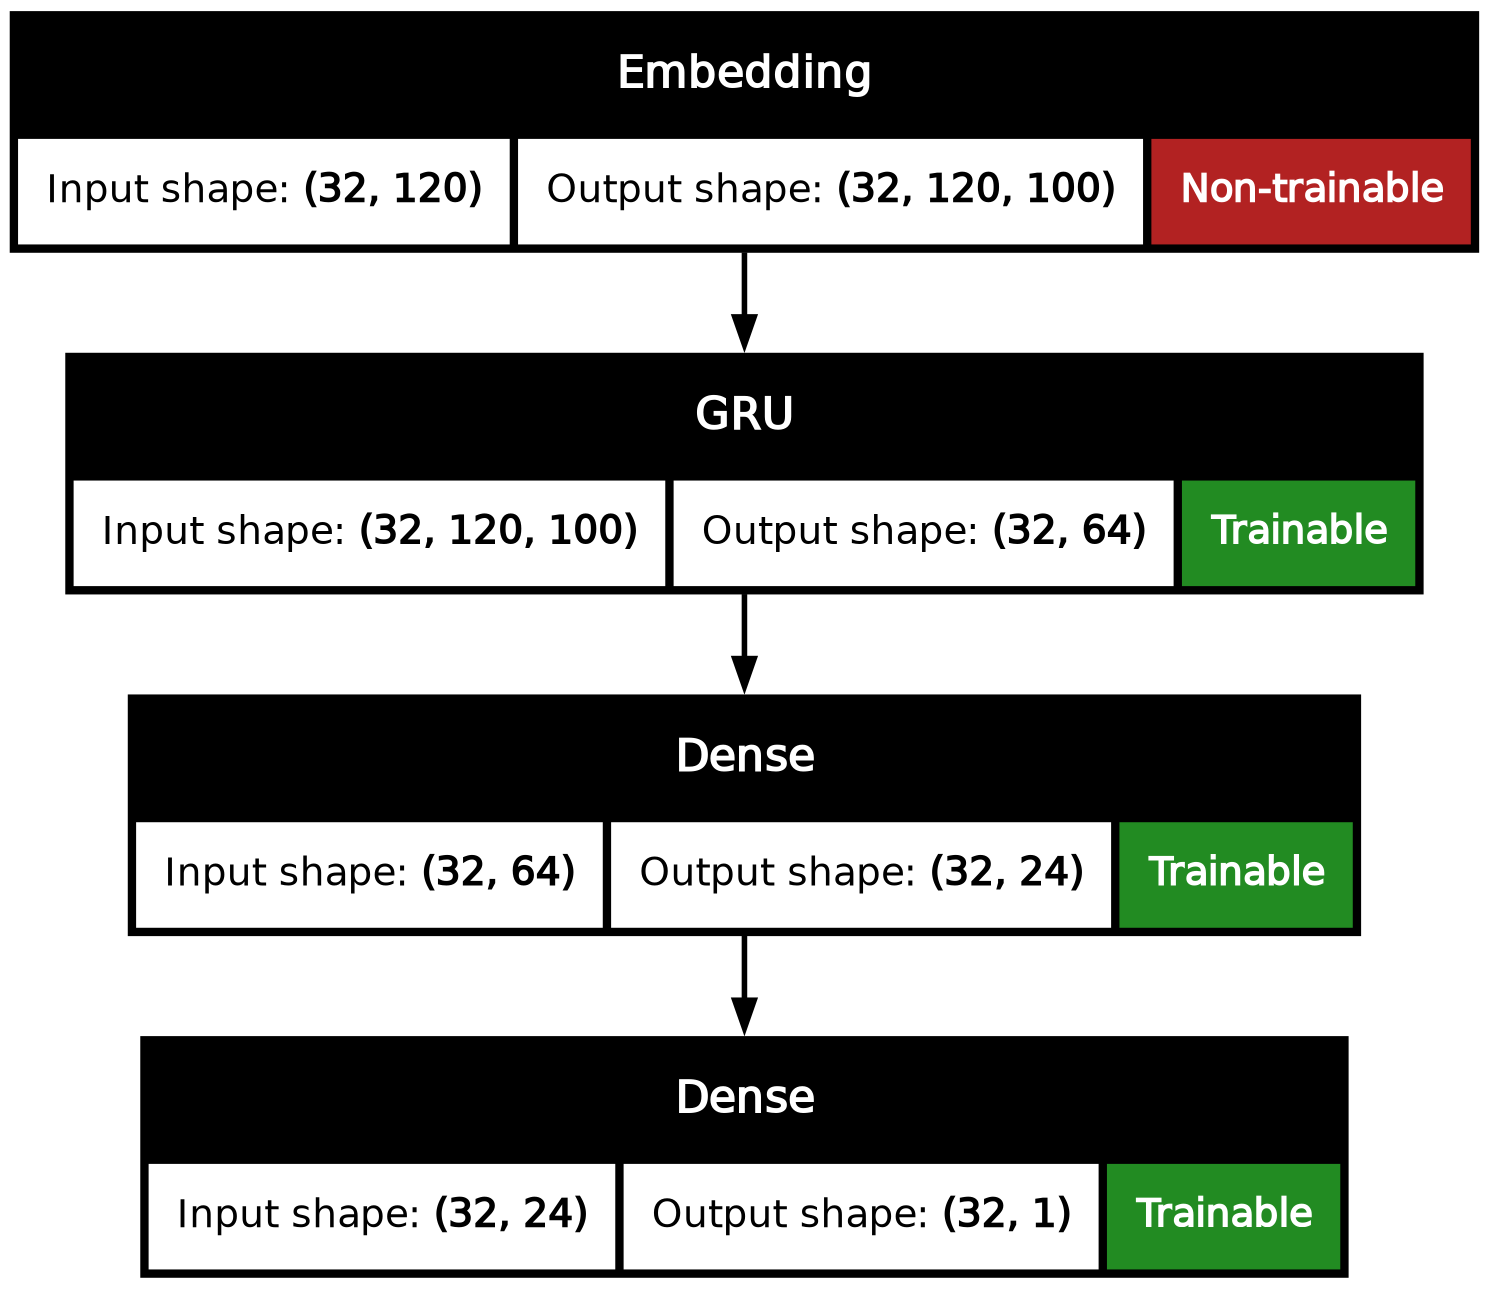

In [ ]:
tf.keras.utils.plot_model(gru, show_shapes=True, show_trainable = True)

In [ ]:
results = gru.evaluate(test_padded, test_labels, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5474 - loss: 0.6876


In [ ]:
plot_history(history)

In [ ]:
predictions = gru.predict(test_padded)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


In [ ]:
gru_prediction = np.where(predictions > 0.5, 1, 0)

In [ ]:
from sklearn import metrics
gru_performance = metrics.classification_report(test_labels,gru_prediction, target_names= ['0', '1'])
print(gru_performance)

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      5000
           1       0.83      0.83      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



### LSTM model

In [ ]:
# LSTM model model initialization with pre-trained Glove
lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    18,062,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,062,000 (68.90 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,062,000 (68.90 MB)

In [ ]:
# fit model
early_stop = EarlyStopping(monitor='val_accuracy', patience=2, mode='max', restore_best_weights=True)

num_epochs = 50
history = lstm.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)

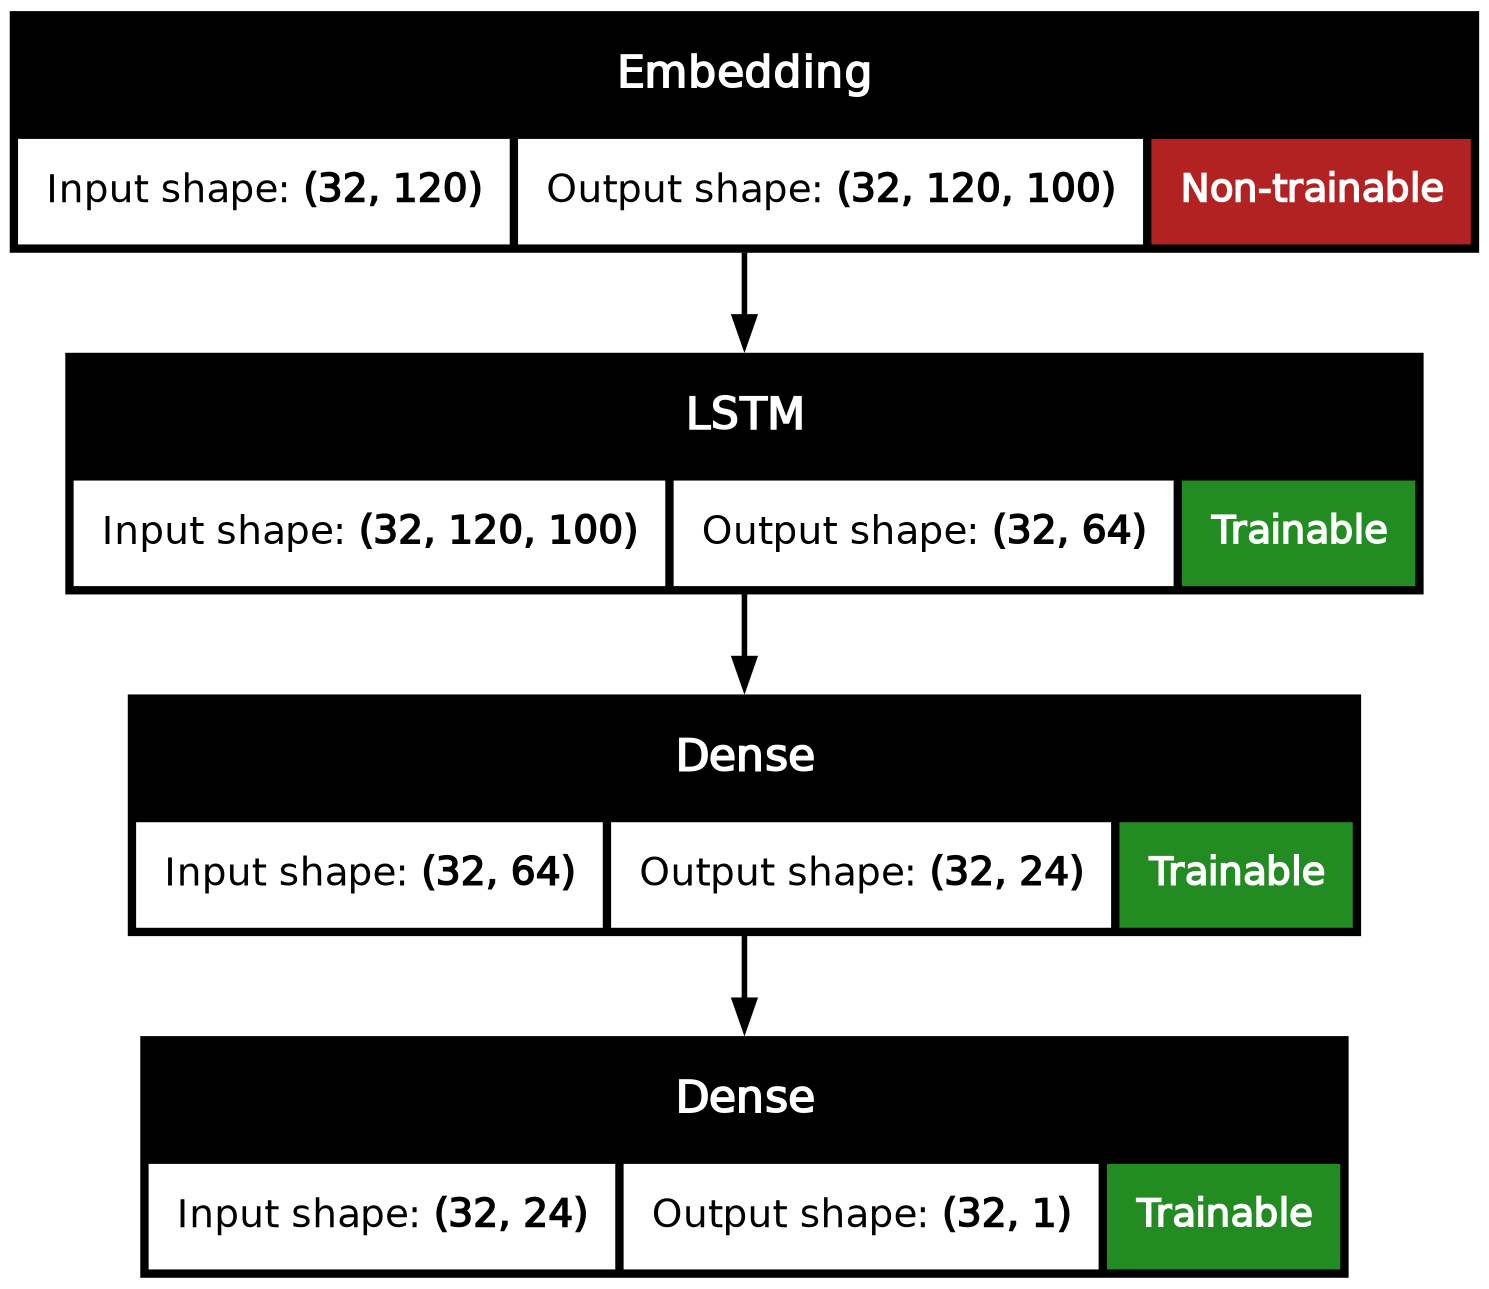

In [ ]:
tf.keras.utils.plot_model(lstm, show_shapes=True, show_trainable = True)

In [ ]:
results = lstm.evaluate(test_padded, test_labels, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6307 - loss: 0.6561


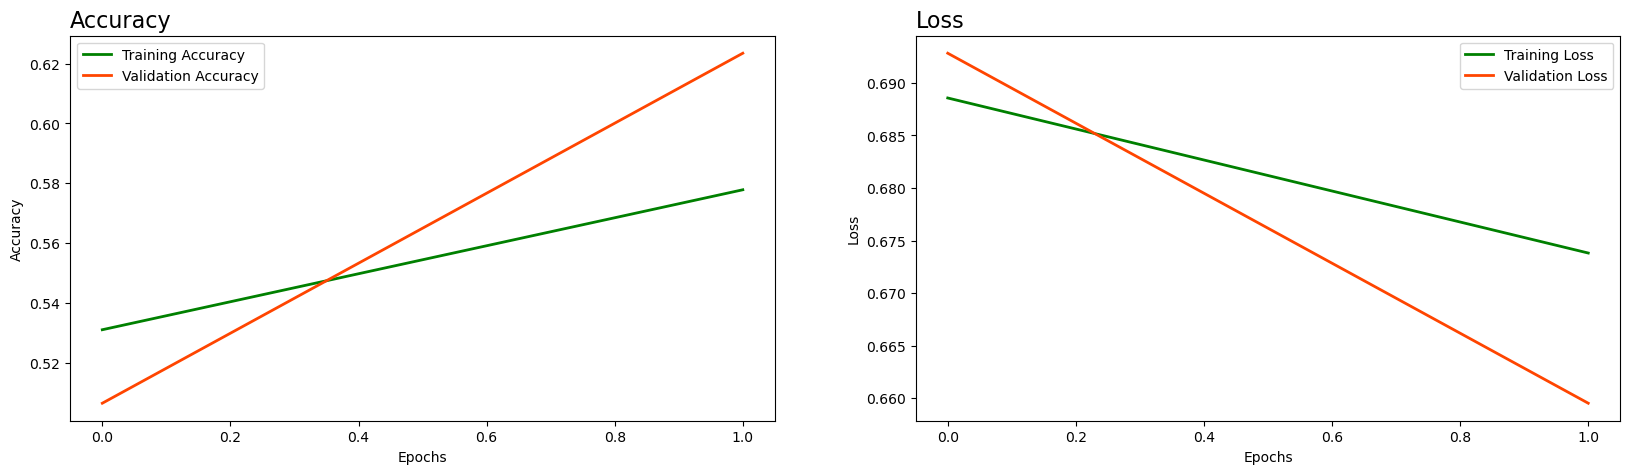

In [ ]:
plot_history(history)

In [ ]:
predictions = lstm.predict(test_padded)
lstm_prediction = np.where(predictions > 0.5, 1, 0)
from sklearn import metrics
lstm_performance = metrics.classification_report(test_labels,lstm_prediction, target_names= ['0', '1'])
print(lstm_performance)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
              precision    recall  f1-score   support

           0       0.68      0.49      0.57      5000
           1       0.60      0.77      0.67      5000

    accuracy                           0.63     10000
   macro avg       0.64      0.63      0.62     10000
weighted avg       0.64      0.63      0.62     10000



### Bidrectional LSTM

In [ ]:
# BiLSTM model model initialization with pre-trained Glove
blstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
blstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m, precision_m, recall_m])

# model summary
blstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    18,062,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,062,000 (68.90 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,062,000 (68.90 MB)

In [ ]:
#fit model
from keras.callbacks import EarlyStopping
# import keras.backend as K

early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

num_epochs = 50
history = blstm.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)


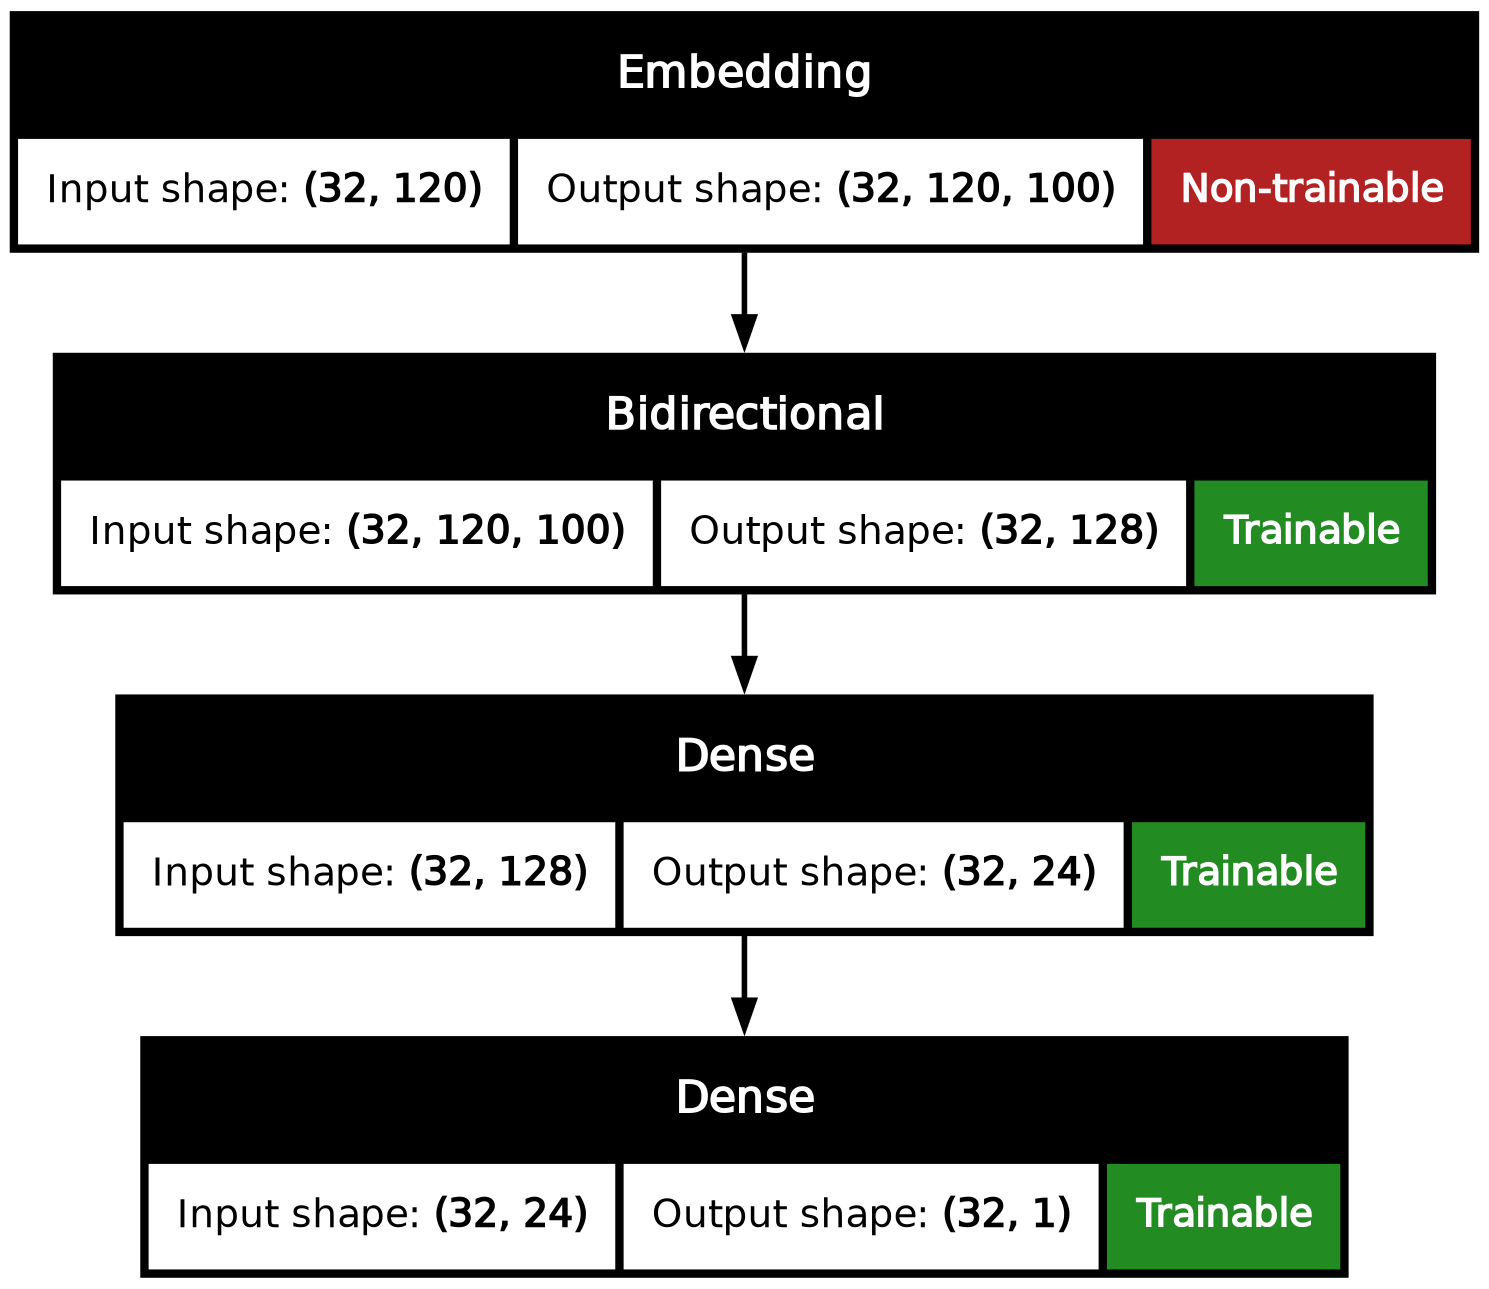

In [ ]:
tf.keras.utils.plot_model(blstm, show_shapes=True, show_trainable = True)

In [ ]:
results = blstm.evaluate(test_padded, test_labels, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8335 - f1_m: 0.8375 - loss: 0.3763 - precision_m: 0.8191 - recall_m: 0.8664


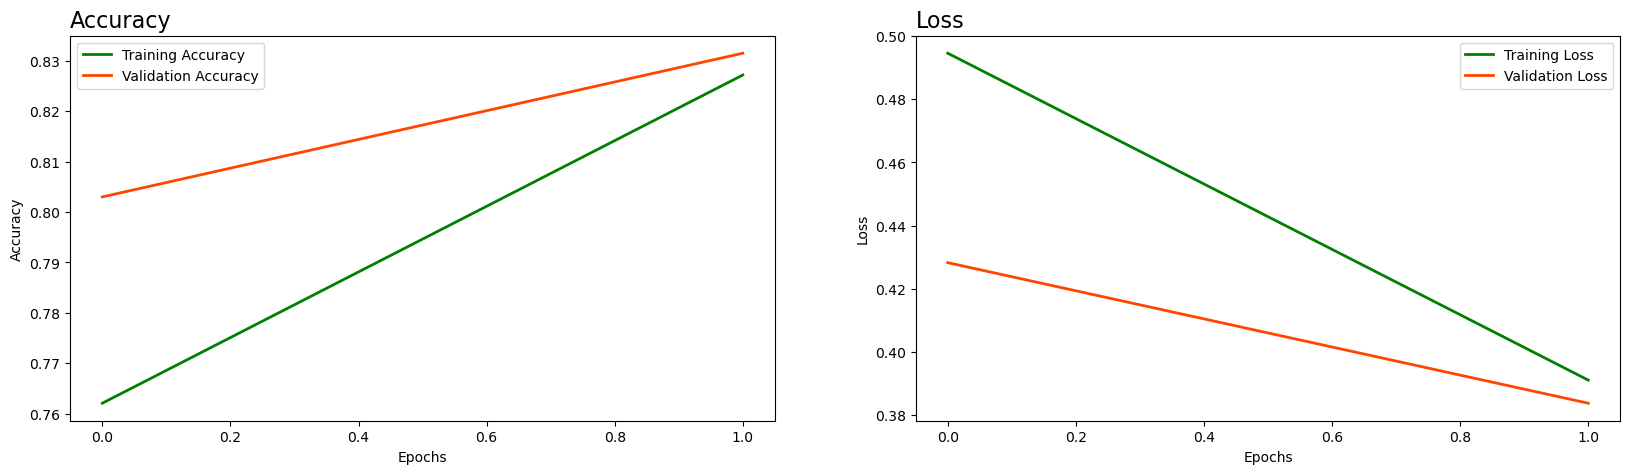

In [ ]:
plot_history(history)

In [ ]:
predictions = blstm.predict(test_padded)
blstm_prediction = np.where(predictions > 0.5, 1, 0)
from sklearn import metrics
blstm_performance = metrics.classification_report(test_labels,blstm_prediction, target_names= ['0', '1'])
print(blstm_performance)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      5000
           1       0.81      0.87      0.84      5000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



### Bidirectional LSTM - Concatenate

In [ ]:
blstmc = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

# compile model
blstmc.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m, precision_m, recall_m])

# model summary
blstmc.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │    18,062,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,062,000 (68.90 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,062,000 (68.90 MB)

In [ ]:
#fit model
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

num_epochs = 50
# num_epochs = 1
history = blstmc.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)


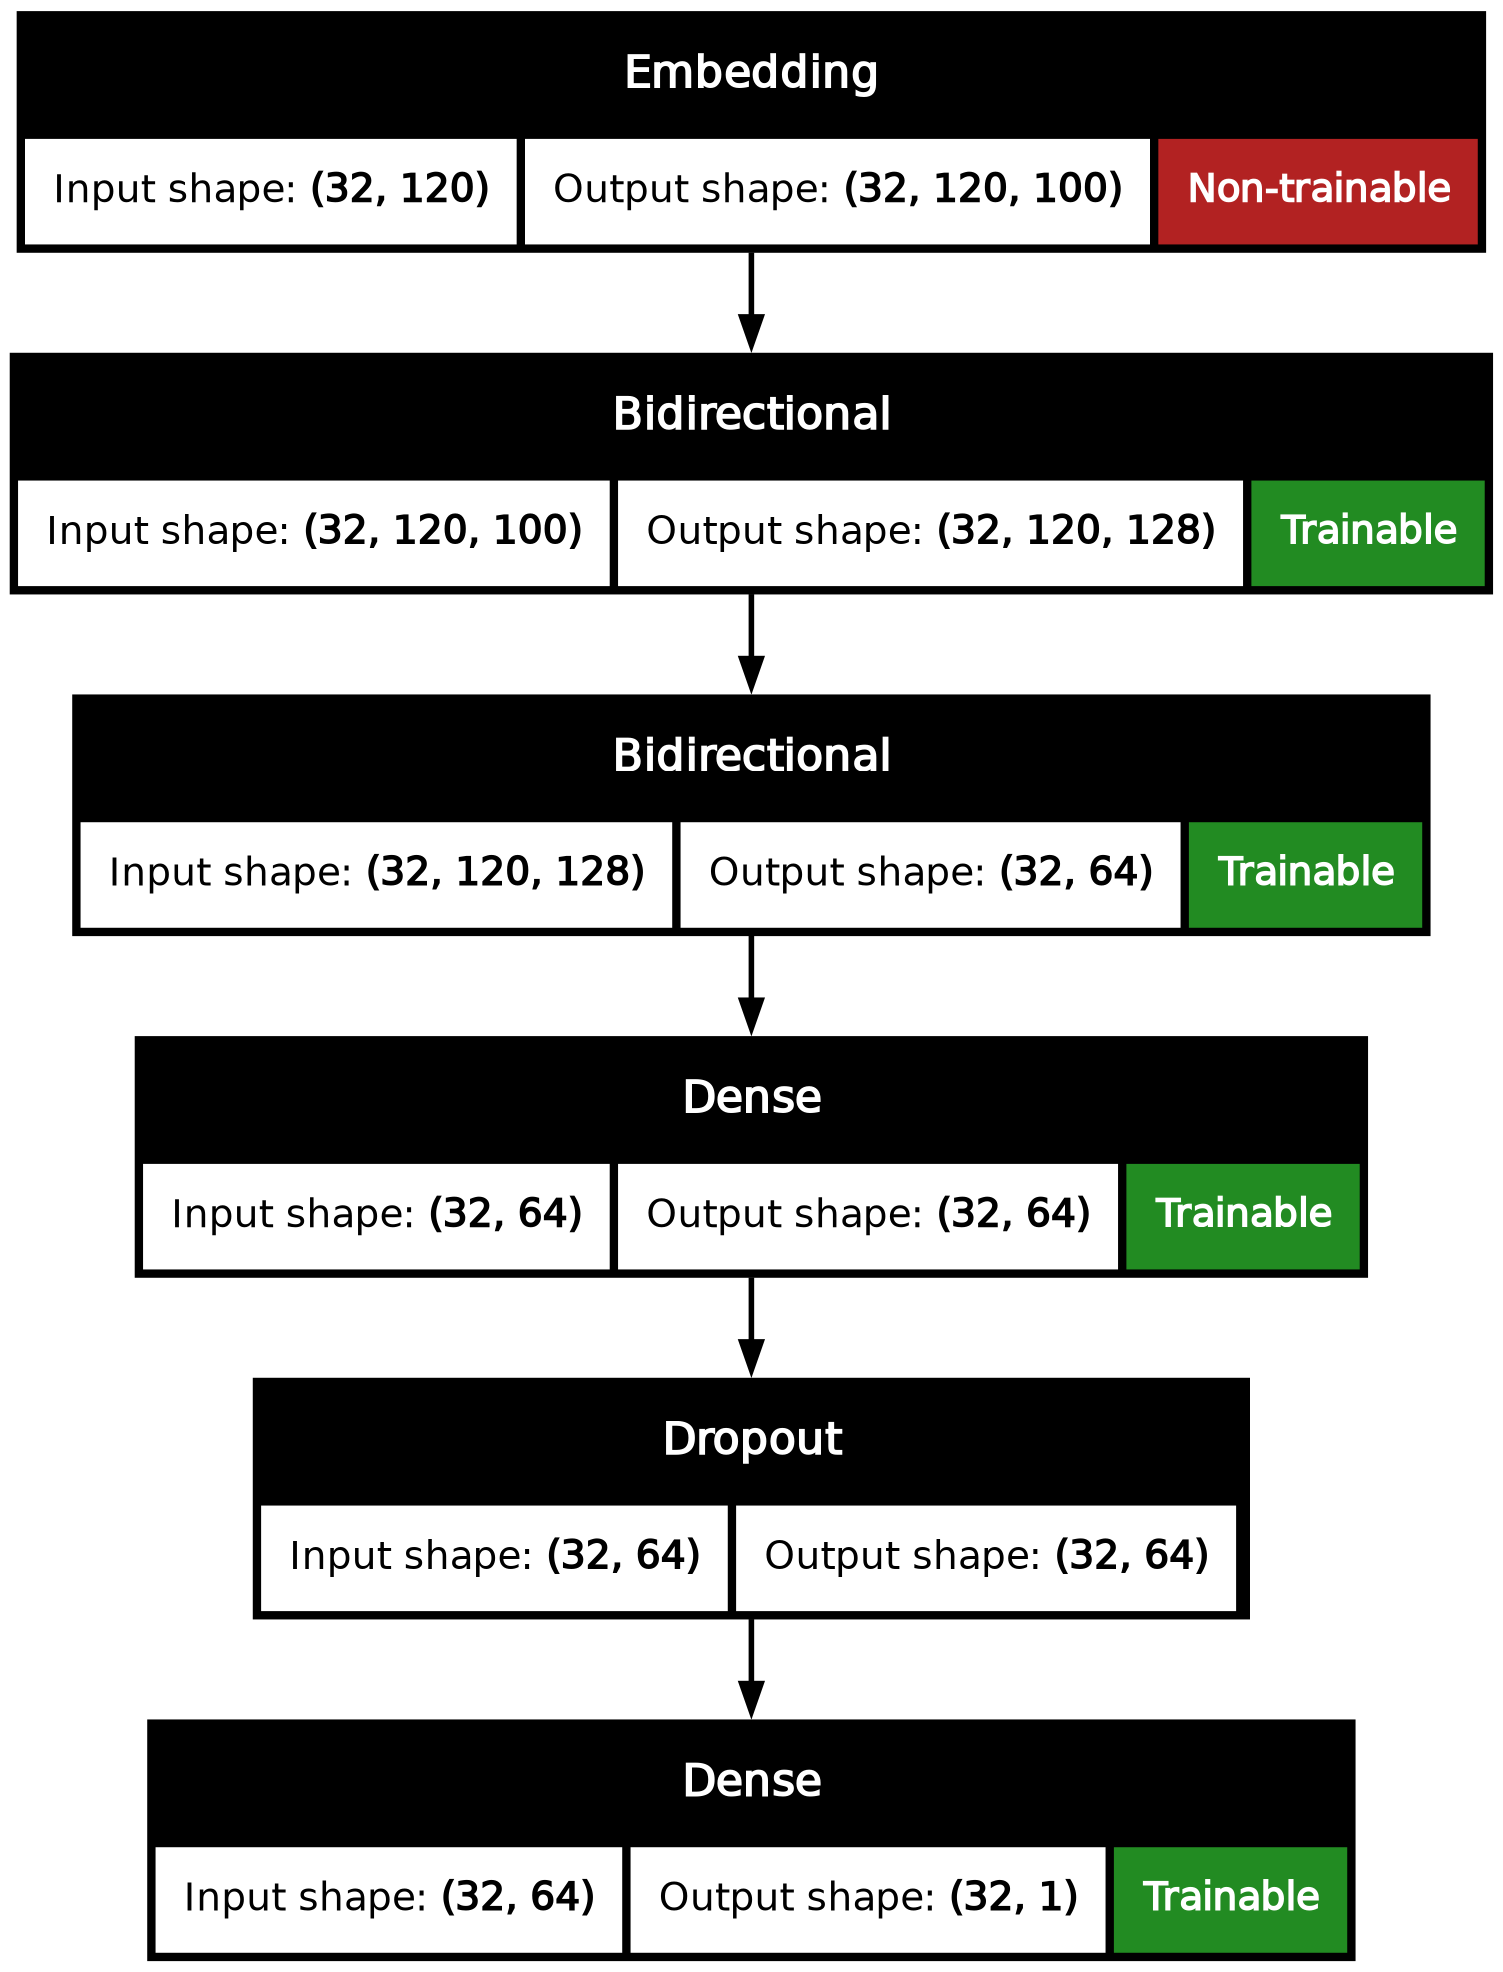

In [ ]:
tf.keras.utils.plot_model(blstmc, show_shapes=True, show_trainable = True)

In [ ]:
results = blstmc.evaluate(test_padded, test_labels, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8554 - f1_m: 0.8559 - loss: 0.3676 - precision_m: 0.8543 - recall_m: 0.8668


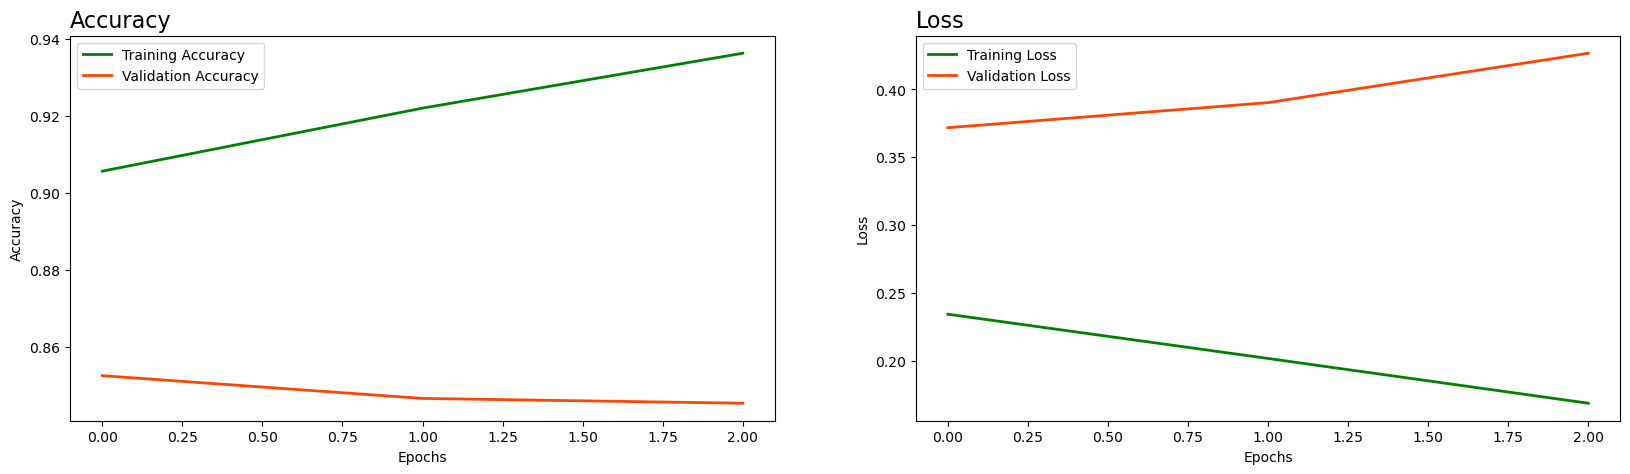

In [ ]:
plot_history(history)

In [ ]:
predictions = blstmc.predict(test_padded)
blstmc_prediction = np.where(predictions > 0.5, 1, 0)
from sklearn import metrics
blstmc_performance = metrics.classification_report(test_labels,blstmc_prediction, target_names= ['0', '1'])
print(blstmc_performance)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      5000
           1       0.84      0.87      0.86      5000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



### Bidirectional LSTM with attention

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Attention, concatenate,GlobalAveragePooling1D
from tensorflow.keras.models import Model

query_tensor = Input(shape=(max_length,), dtype='int32')
value_tensor = Input(shape=(max_length,), dtype='int32')


embedding_layer = Embedding(len(word_index) + 1,  embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)
query_embedding = embedding_layer(query_tensor)
value_embedding = embedding_layer(value_tensor)
bilstm_layer = Bidirectional(LSTM(64, return_sequences=True))
query_lstm = bilstm_layer(query_embedding)
value_lstm = bilstm_layer(value_embedding)
attention_layer = Attention()
attention_output = attention_layer([query_lstm, value_lstm])
merged = concatenate([query_lstm, attention_output, value_lstm])
merged = GlobalAveragePooling1D()(merged) # add this if you see an error 'target and output must have same shape'

dense_layer = Dense(64, activation='relu')(merged)
output_layer = Dense(1, activation='sigmoid')(dense_layer)
model = tf.keras.Model(inputs=[query_tensor, value_tensor], outputs=output_layer)



# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 120, 100)  │ 18,062,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 120, 128)  │     84,480 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ embedding_4[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 120, 128)  │          0 │ bidirectional_3[… │
│ (Attention)         │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 120, 384)  │          0 │ bidirectional_3[… │
│ (Concatenate)       │                   │            │ attention[0][0],  │
│                     │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ concatenate[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     24,640 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,171,185 (69.32 MB)

 Trainable params: 109,185 (426.50 KB)

 Non-trainable params: 18,062,000 (68.90 MB)

In [ ]:
#fit model
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

num_epochs = 50
# num_epochs = 10

model.fit([train_padded, train_padded], train_labels,  batch_size= 32, epochs= num_epochs, validation_split=0.3, callbacks=[early_stop])


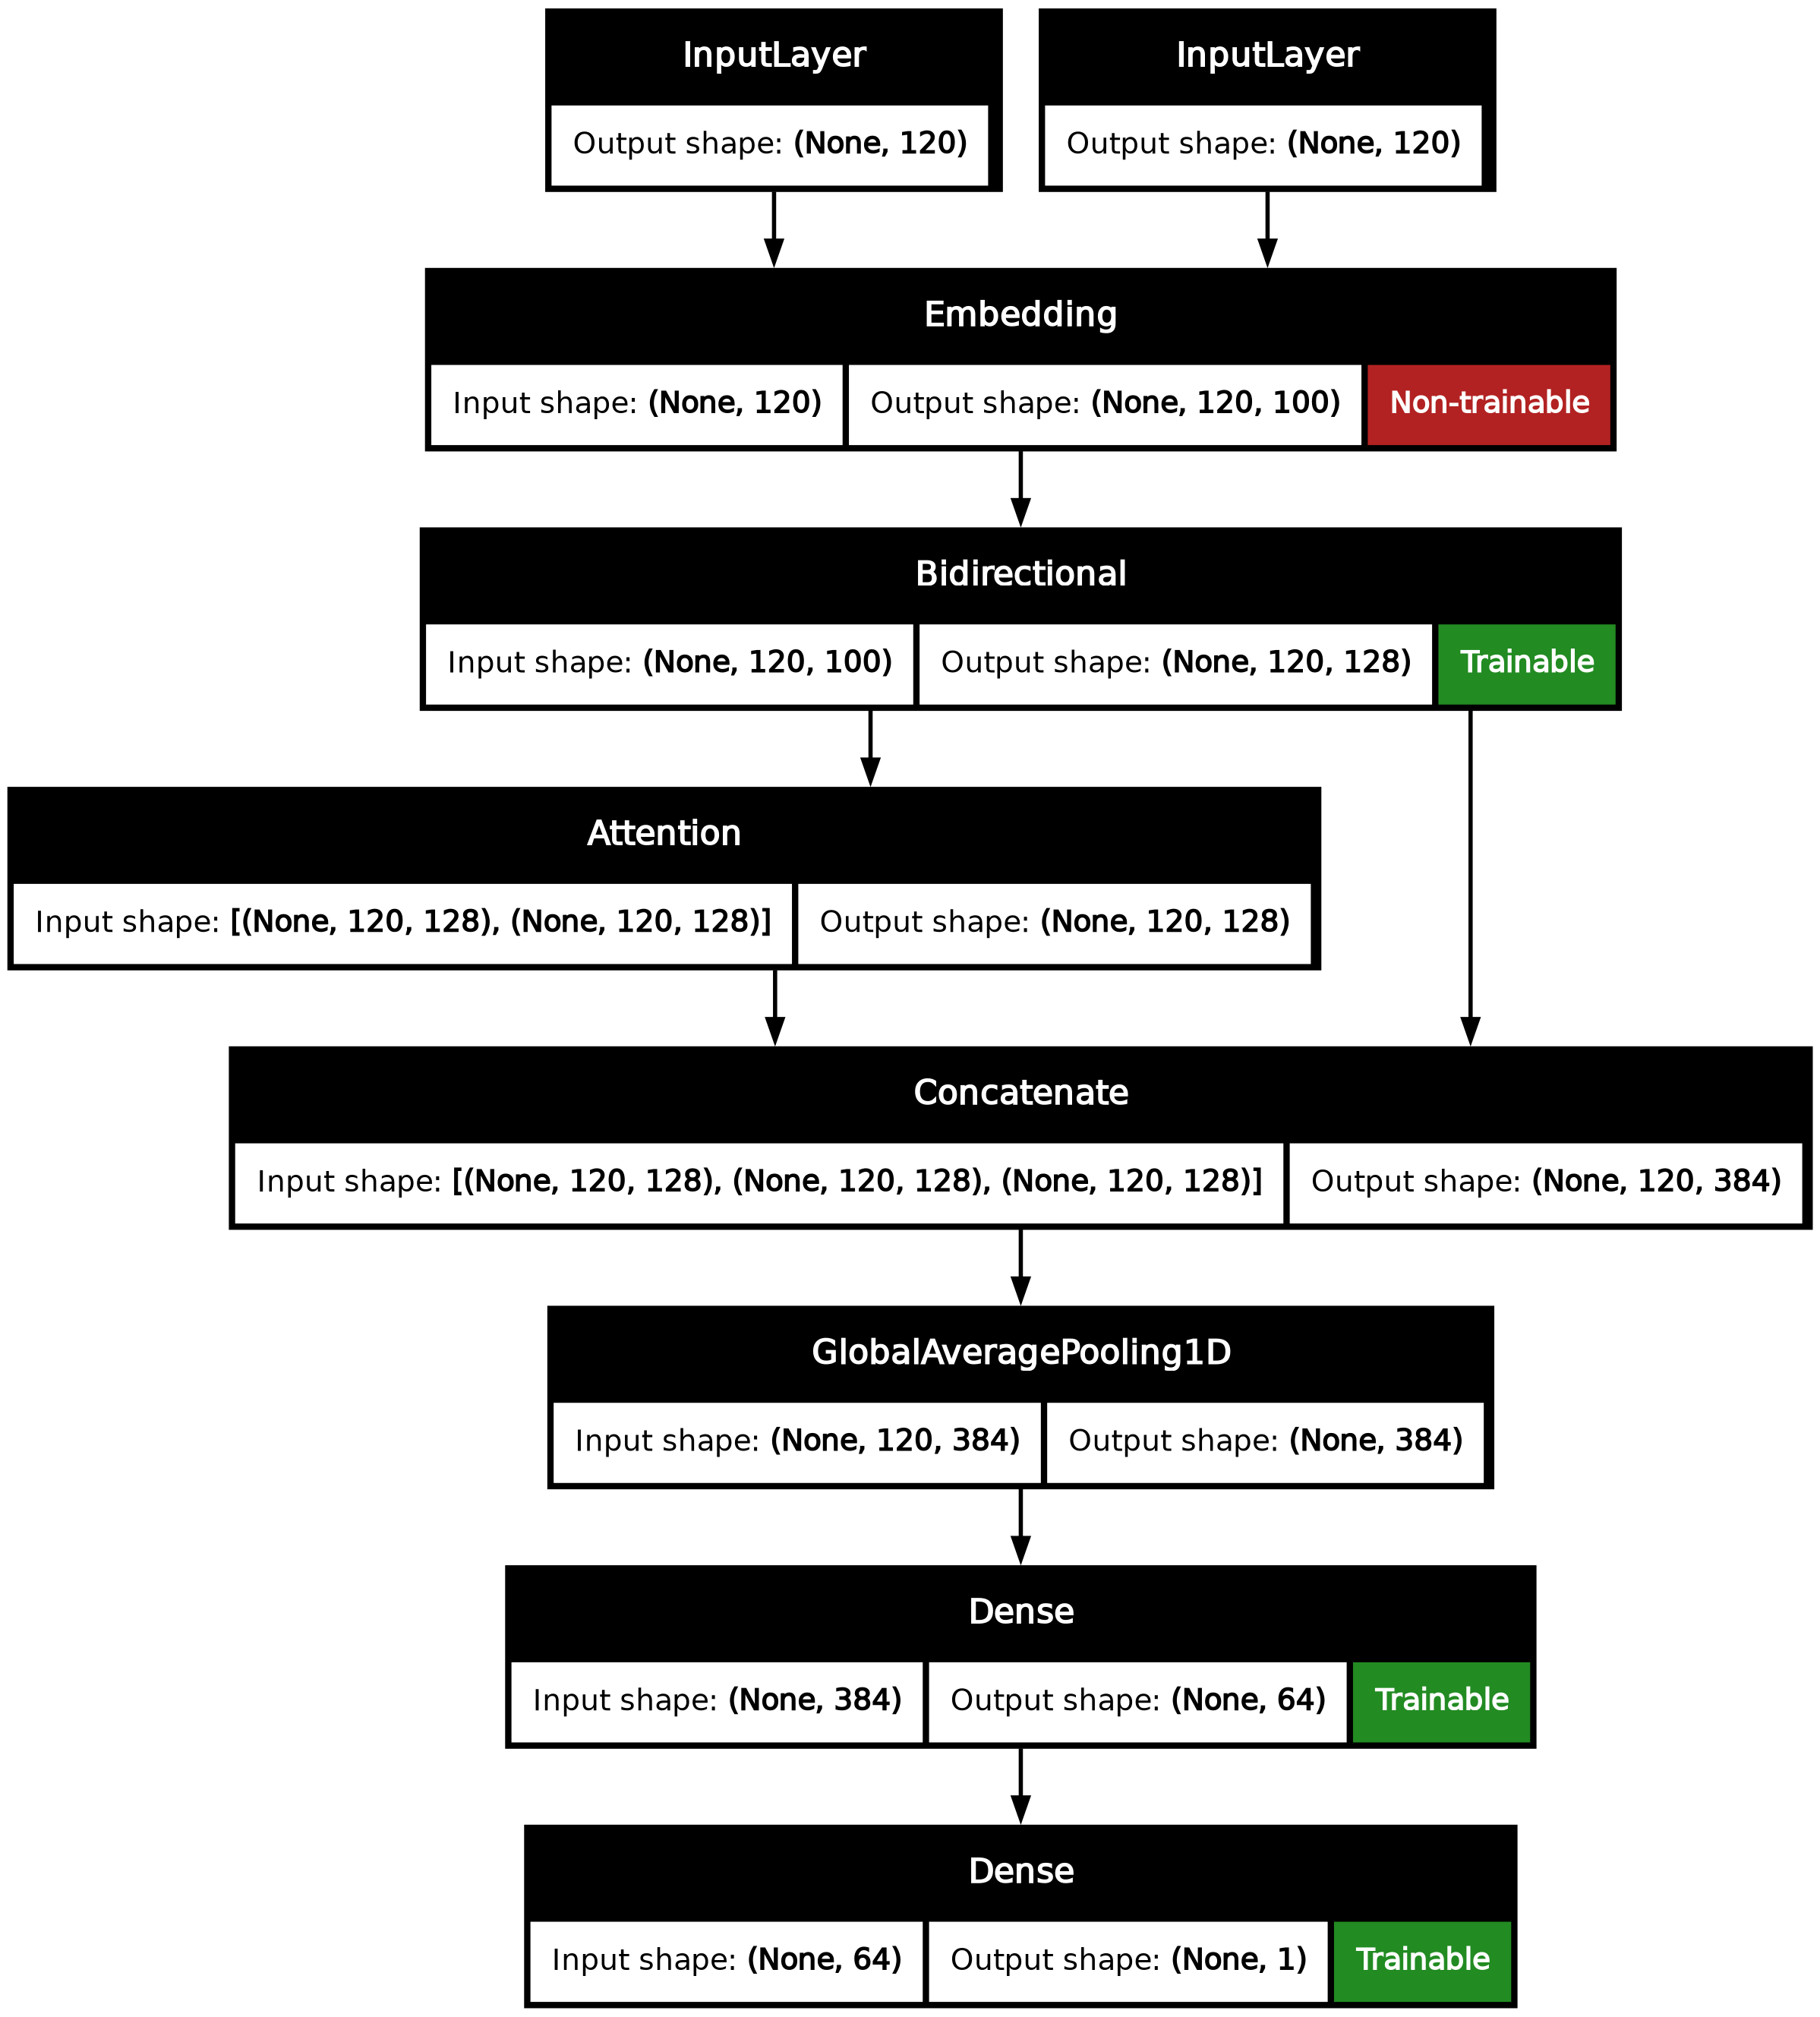

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_trainable = True)

In [ ]:
results = model.evaluate([test_padded, test_padded], test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8356 - loss: 0.3680


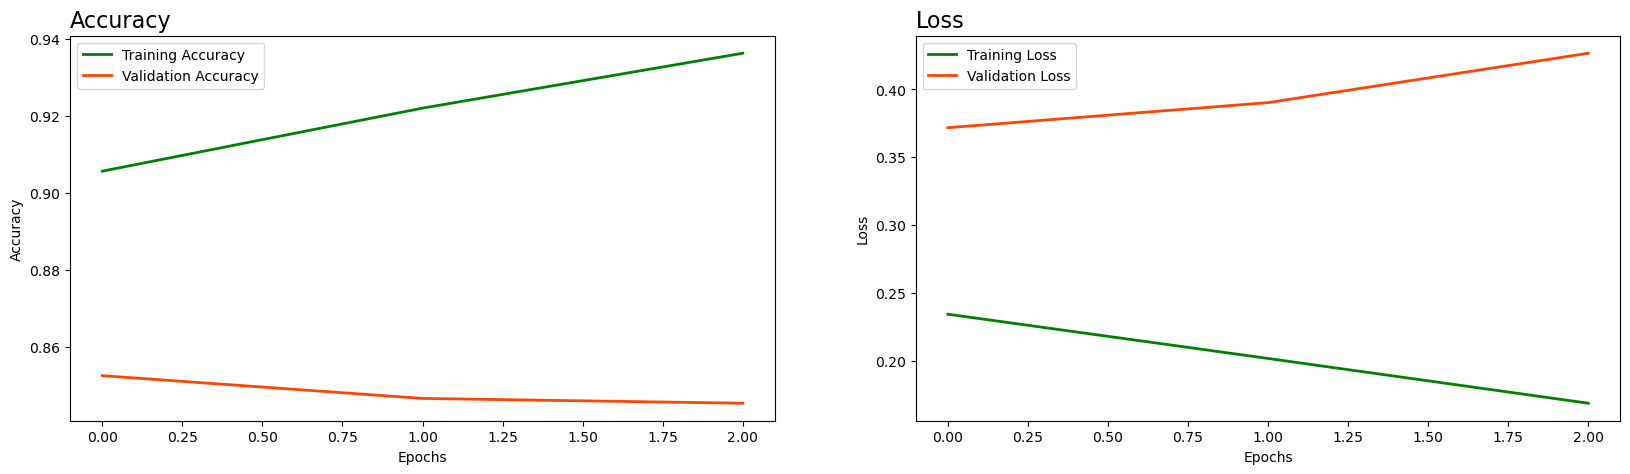

In [ ]:
plot_history(history)

## Build Deep Learning models with Trainable Embeddings

## BLSTM with Trainable Embeddings

In [ ]:
# BiLSTM model with trainable embeddings

# model initialization
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m, precision_m, recall_m])

# model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#fit model
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

num_epochs = 50
# num_epochs = 1
history = model.fit(train_padded, train_labels,
                    epochs=num_epochs, verbose=1, callbacks=[early_stop],
                    validation_split=0.3)


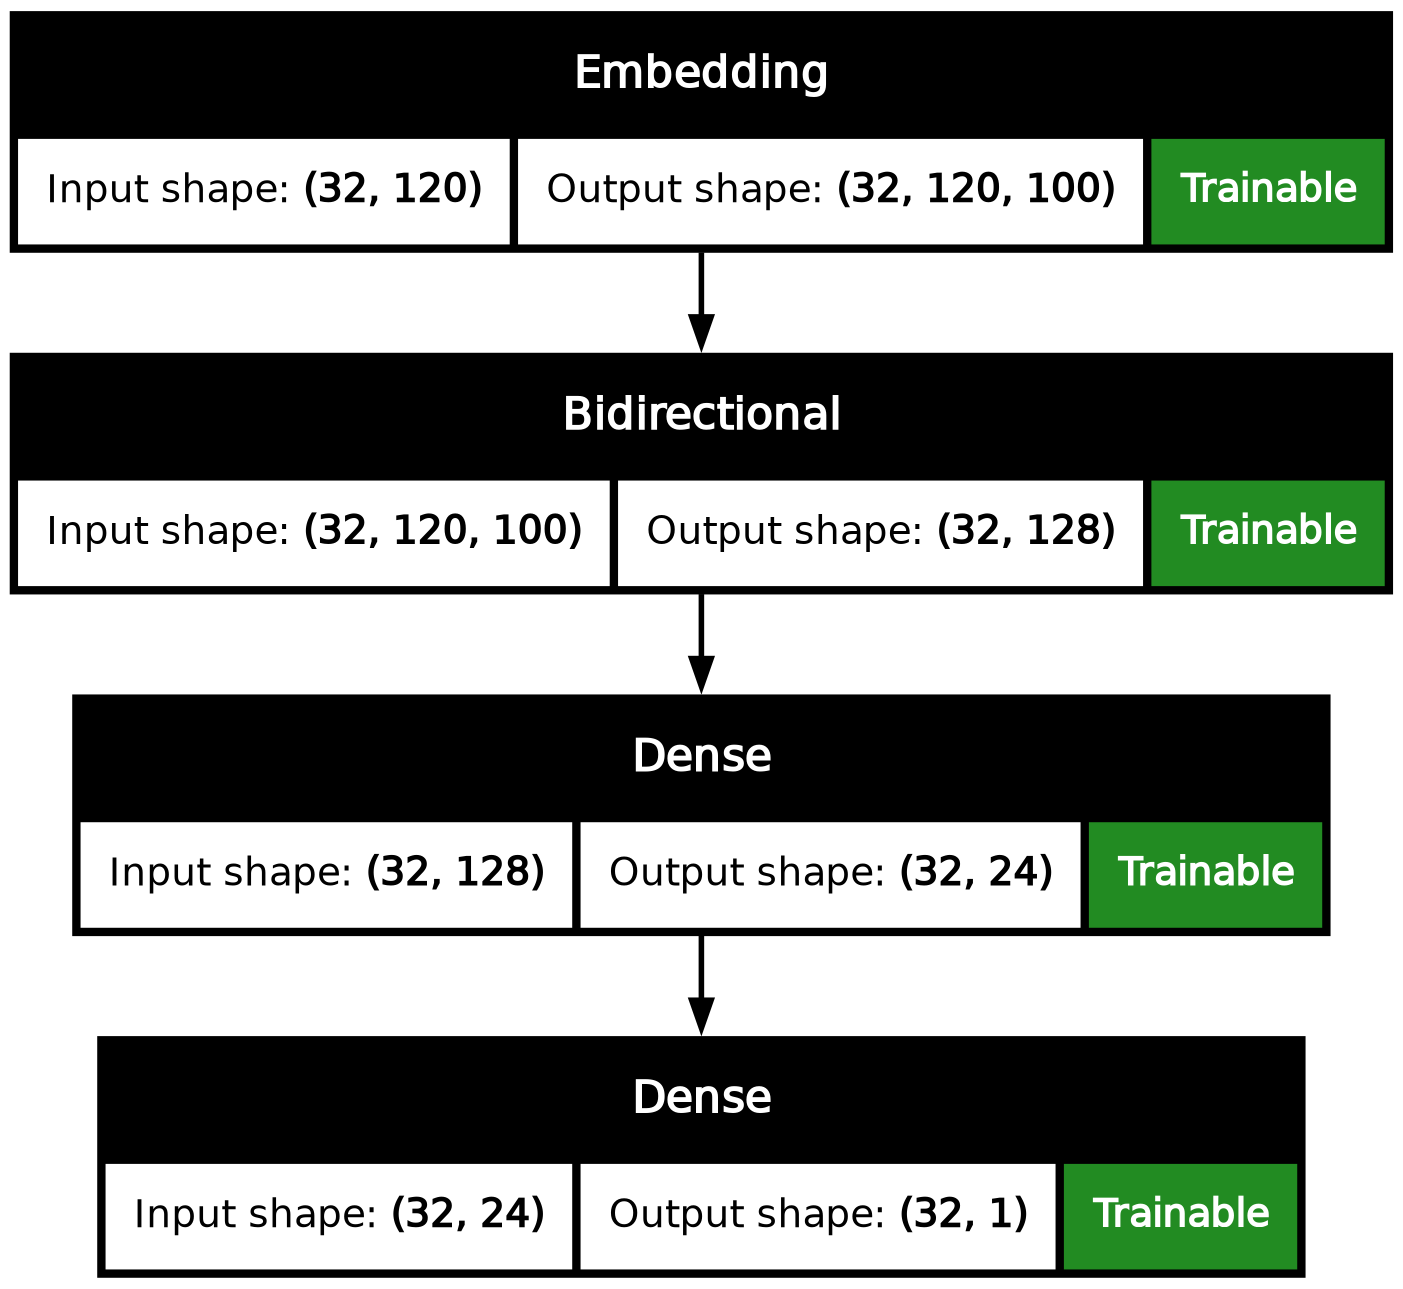

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_trainable = True)

In [ ]:
results = model.evaluate(test_padded, test_labels, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8664 - f1_m: 0.8623 - loss: 0.3171 - precision_m: 0.8853 - recall_m: 0.8490


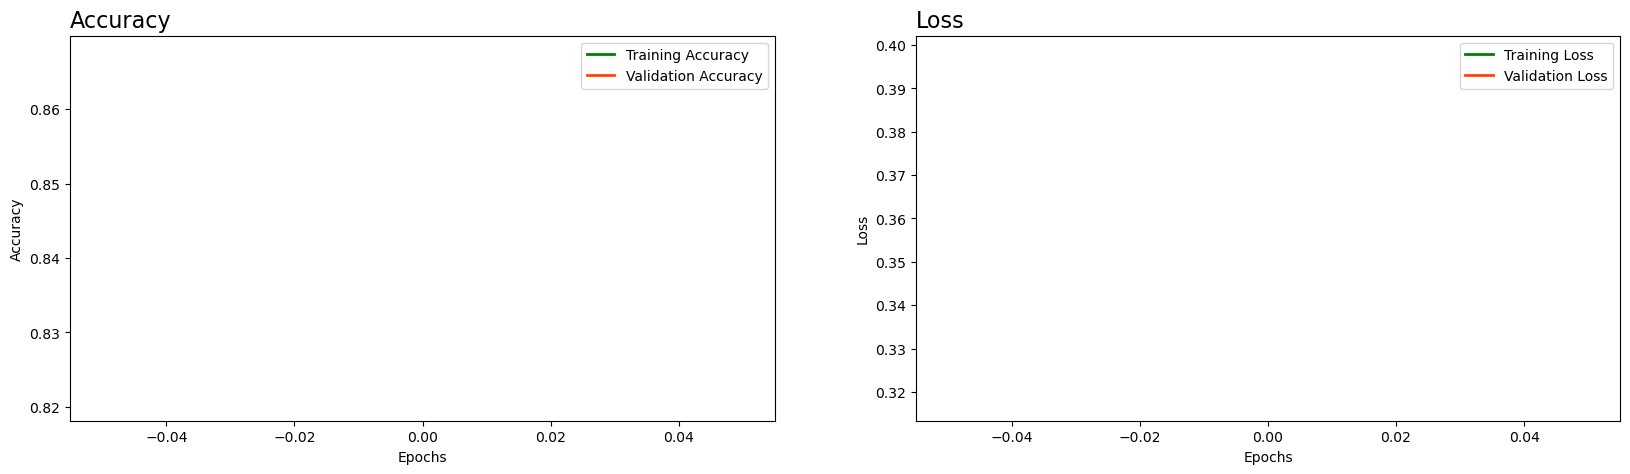

In [ ]:
plot_history(history)

In [ ]:
#BiLSTM with attention and with trainable word embeddings

from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Attention, concatenate
from tensorflow.keras.models import Model

query_tensor = Input(shape=(max_length,), dtype='int32')
value_tensor = Input(shape=(max_length,), dtype='int32')


embedding_layer = tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length)
query_embedding = embedding_layer(query_tensor)
value_embedding = embedding_layer(value_tensor)
bilstm_layer = Bidirectional(LSTM(64, return_sequences=True))
query_lstm = bilstm_layer(query_embedding)
value_lstm = bilstm_layer(value_embedding)
attention_layer = Attention()
attention_output = attention_layer([query_lstm, value_lstm])
merged = concatenate([query_lstm, attention_output, value_lstm])
merged = GlobalAveragePooling1D()(merged) # add this if you see an error 'target and output must have same shape'
dense_layer = Dense(24, activation='relu')(merged)
output_layer = Dense(1, activation='sigmoid')(dense_layer)
model = tf.keras.Model(inputs=[query_tensor, value_tensor], outputs=output_layer)



# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m, precision_m, recall_m])

# model summary
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 120, 100)  │ 18,062,000 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 120, 128)  │     84,480 │ embedding_6[0][0… │
│ (Bidirectional)     │                   │            │ embedding_6[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 120, 128)  │          0 │ bidirectional_5[… │
│ (Attention)         │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 120, 384)  │          0 │ bidirectional_5[… │
│ (Concatenate)       │                   │            │ attention_1[0][0… │
│                     │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ concatenate_1[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 24)        │      9,240 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         25 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,155,745 (69.26 MB)

 Trainable params: 18,155,745 (69.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#fit model
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)

num_epochs = 50
# num_epochs = 1

model.fit([train_padded, train_padded], train_labels,  batch_size= 32, epochs= num_epochs, validation_split=0.33, callbacks=[early_stop])


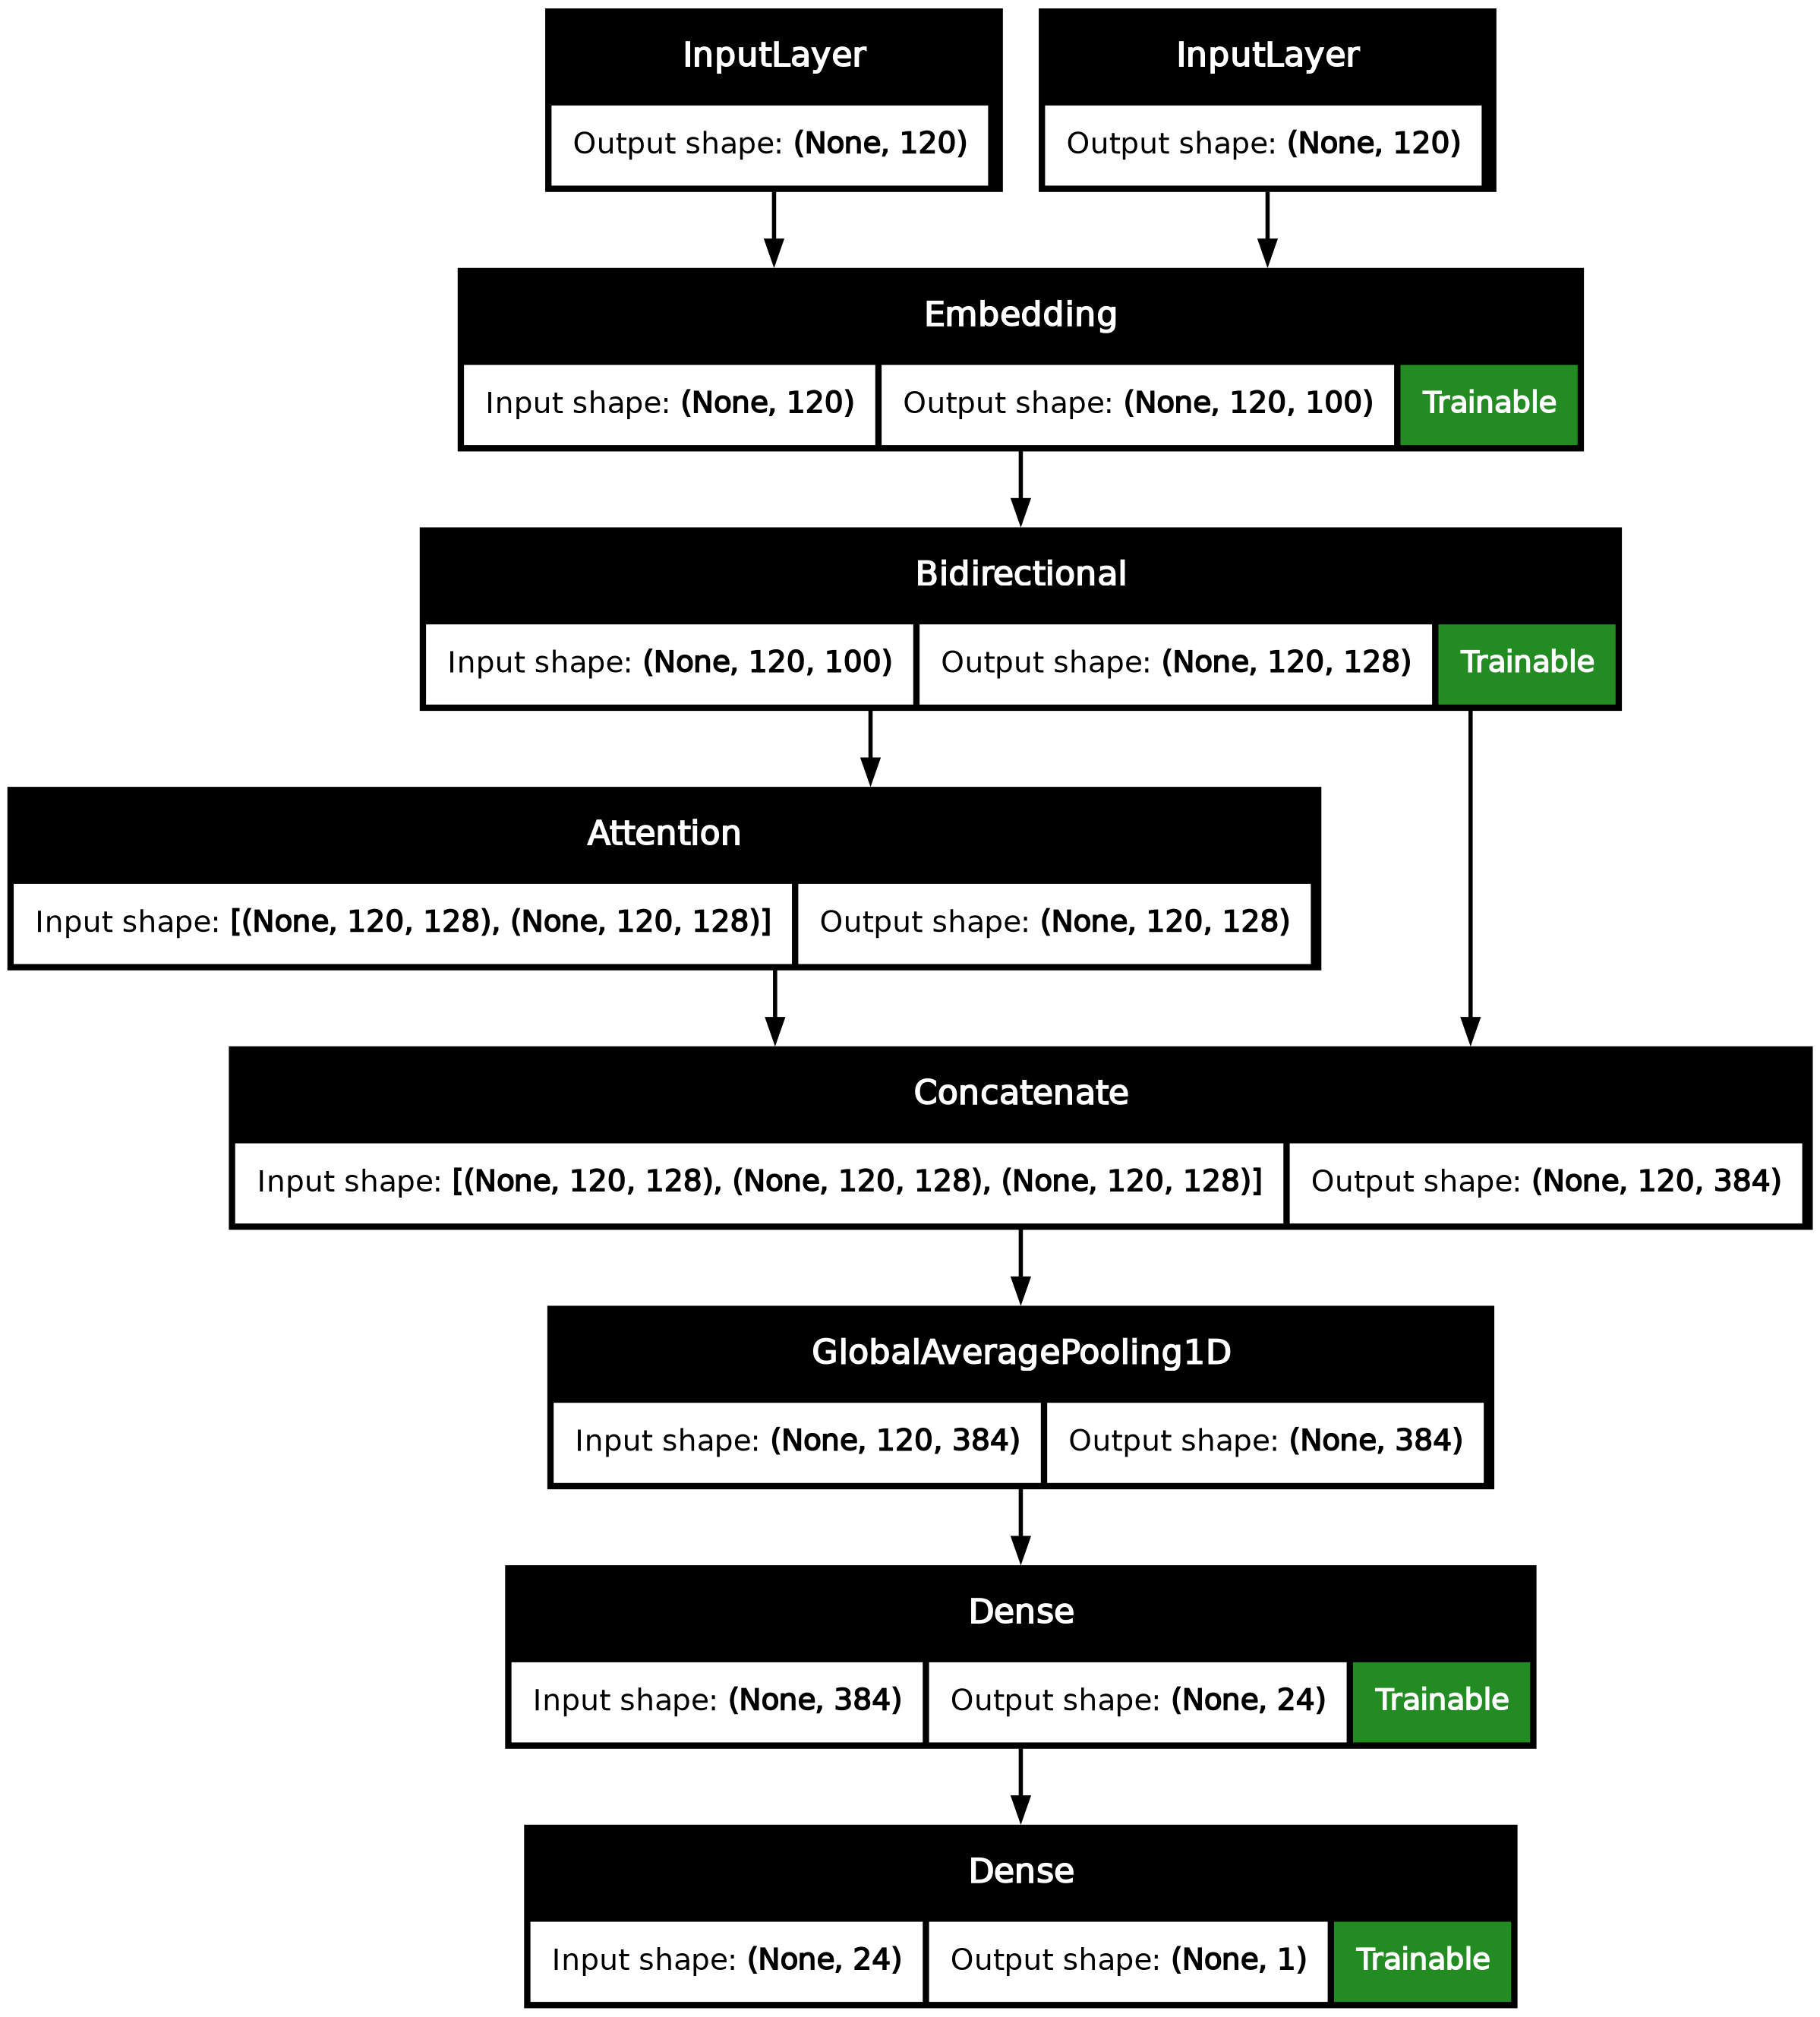

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_trainable = True)

In [ ]:
results = model.evaluate([test_padded, test_padded], test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8642 - f1_m: 0.8553 - loss: 0.3182 - precision_m: 0.9049 - recall_m: 0.8192


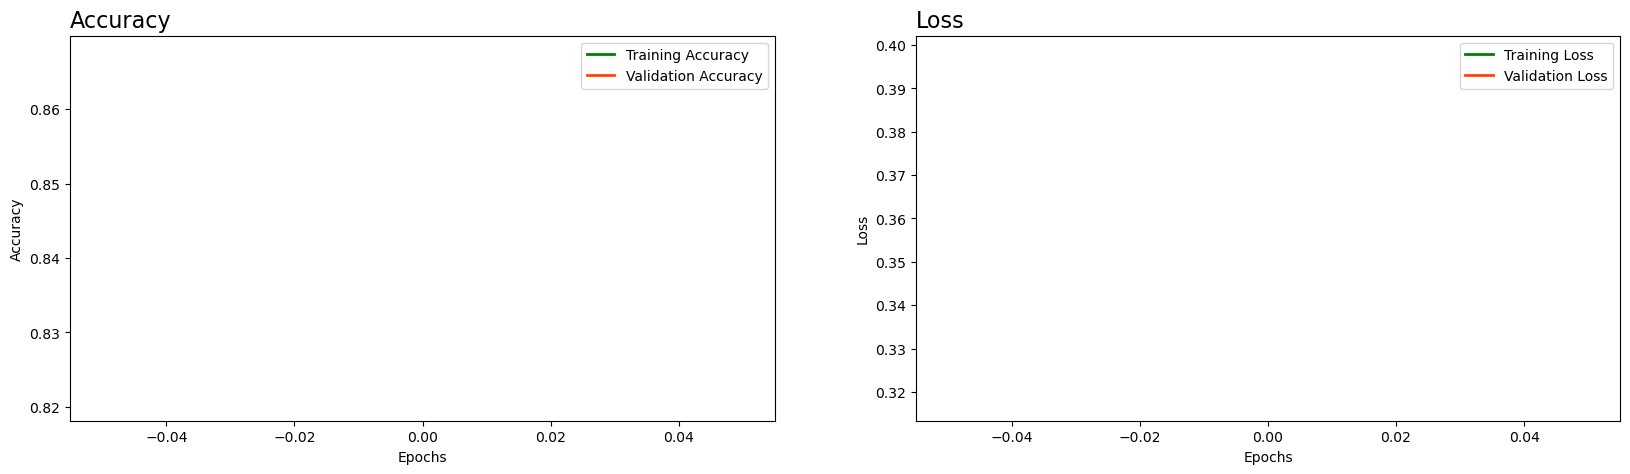

In [ ]:
plot_history(history)